# Backtest

In [41]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
np.seterr(divide="ignore", invalid="ignore")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", style="white", color_codes=True)
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")
from build import build_features
from build import build_labels
from build import build_train_test
from backtest import backtest_report, frame_to_signals, signals_to_positions, position_to_margin

In [79]:
def idx_margin(data, margin, idx="DAX", method="percent"):
    idx_close = data.close.loc[idx].reindex(margin.index, method="ffill")
    if method == "log":
        idx_margin = np.log(idx_close / idx_close.shift(1))
    elif method == "percent":
        idx_margin = idx_close.pct_change(1)
    return idx_margin

def backtest_margin(
    backtest_data,
    features,
    estimator,
    test_start="2011-12-01",
    test_end="2021-03-01",
    months=3,
    n=10,
    weight="equal",
    method="percent",
):
    X = features.xs(slice(test_start, test_end), level="date", drop_level=False)
    data = backtest_data.xs(slice(test_start, test_end), level="date", drop_level=False)
    short_signal, long_signal = frame_to_signals(X, estimator)
    short_position, long_position = signals_to_positions(
        short_signal, long_signal, n, months, weight
    )
    long_margin = position_to_margin(data, long_position, method=method)
    return long_margin

## Fundamental

In [2]:
# read backtest data
backtest_data=pd.read_parquet("../data/backtest-0.1.1.parquet")
# select stocks with market cap > 1 million, trading price > 5 as stock universe
computed_data = pd.read_parquet("../data/computed-0.1.1.parquet")
gvkeys = computed_data[(computed_data.mcap > 1e6) & (computed_data.prccd > 5)].index.get_level_values("gvkey").unique()
universe = computed_data.loc[gvkeys]

### Hydroxyibuprofen
Hydroxyibuprofen use a subset of factors, which are purely fundamental factors.

In [3]:
def hydroxyibuprofen(df):
    df.eval(
        """
        intangible_rdm=xrd / mcap
        market_dyr=dvc * 10 ** 6 / cshoc / prccd
        market_pe=mcap / (nicon * 10 ** 6)
        market_pch=mcap / (oancf * 10 ** 6)
        market_ps=mcap / (revt * 10 ** 6)
        market_mb=mcap / (ceq * 10 ** 6)
        market_evs=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (revt * 10 ** 6)
        market_eveda=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (ebitda * 10 ** 6)
        market_eve=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (ebit * 10 ** 6)
        market_evedacpx=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / ((ebitda - capx) * 10 ** 6)
        market_evocf=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / ((oancf) * 10 ** 6)
        """,
        inplace=True,
    )
    return df.loc[(df.mcap > 1e6) & (df.prccd > 5),:].drop(columns=["country", "sic", "cshoc", "act", "att", "ap", "capx", "ceq", "ch", "che", "chee", "cogs", "dlc", "dltis", "dltr", "dltt", "dp", "dv", "dvc", "dvt", "dlcch", "ebit", "ebitda", "fincf", "gdwl", "icapt", "intan", "invt", "ivaeq", "ivao", "ivncf", "ivst", "lct", "ltt", "mib", "nicon", "oancf", "pi", "ppegt", "ppent", "pstk", "prstkc", "rect", "revt", "seq", "sstk", "teq", "txp", "xint", "xrd", "xsga", "cshoc", "open", "high", "low", "close", "volume"])

Classification report on training set:

              precision    recall  f1-score   support

          -1       0.62      0.57      0.59     39168
           0       0.63      0.01      0.03      8054
           1       0.59      0.75      0.66     43029

    accuracy                           0.60     90251
   macro avg       0.61      0.44      0.43     90251
weighted avg       0.61      0.60      0.57     90251

Classification report on test set:

              precision    recall  f1-score   support

          -1       0.24      0.46      0.32     13779
           0       0.85      0.00      0.01     45571
           1       0.20      0.65      0.31     14999

    accuracy                           0.22     74349
   macro avg       0.43      0.37      0.21     74349
weighted avg       0.61      0.22      0.13     74349



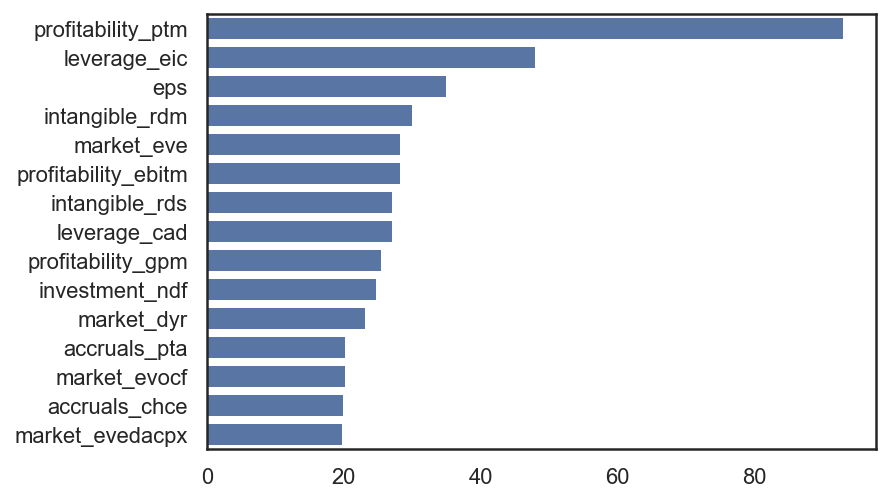

In [4]:
hydroxyibuprofen_features = build_features(universe, hydroxyibuprofen, scale="rank")
hydroxyibuprofen_labels = build_labels(universe, months=3, relative=True)
X_train, y_train, X_test, y_test = build_train_test(
    hydroxyibuprofen_features,
    hydroxyibuprofen_labels,
    train_start="2002-01-01",
    train_end="2016-01-01",
    test_start="2015-12-01",
    test_end="2021-03-01",
    method="multi",
    thres=0.1, 
    extreme=True,
    lower=0.2,
    upper=0.8)

xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric="logloss", n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
importance = pd.Series(data=xgb_clf.get_booster().get_score(importance_type="gain")).sort_values(ascending=False).head(15)
sns.barplot(x=importance, y=importance.index, color="b")
print(f"Classification report on training set:\n")
print(classification_report(y_train, xgb_clf.predict(X_train)))
print(f"Classification report on test set:\n")
print(classification_report(y_test, xgb_clf.predict(X_test)))

Short Only:
Max Drawdown: -1.5297062426688446
Sharpe : -0.5981088522887461
Total Return: -3.7063631171485016
Alpha: -0.61637504366327
Beta: -3.0634508653404264
----------------------------------------
Long Only:
Max Drawdown: -0.6628774126463604
Sharpe : 1.1086781707294102
Total Return: 4.181611781130665
Alpha: 0.688213191317403
Beta: 3.696576276283626
----------------------------------------
Market Neutral:
Max Drawdown: -1.4335124366200347
Sharpe : 0.07698523310932112
Total Return: 0.47524866398215027
Alpha: 0.07183814765413041
Beta: 0.6331254109431991
----------------------------------------


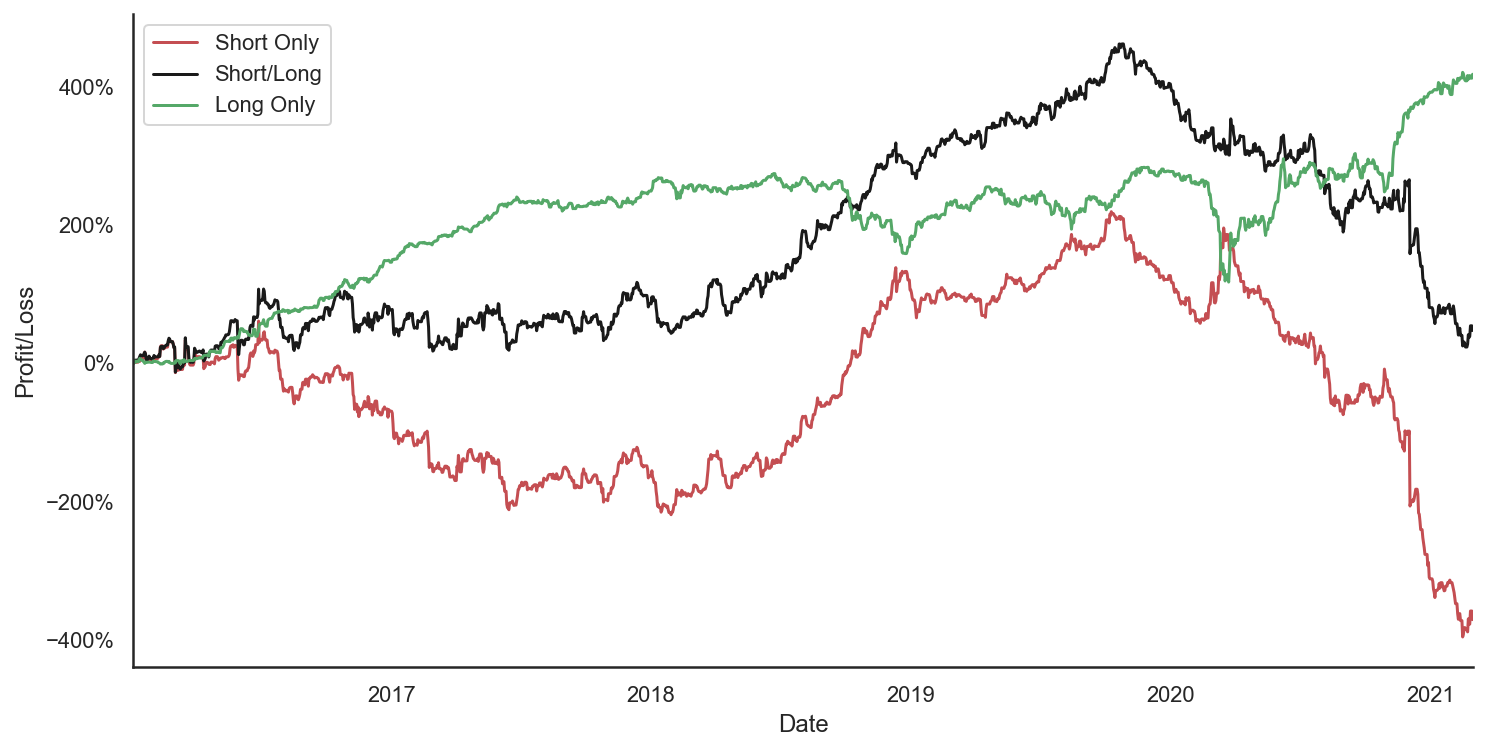

In [5]:
backtest_report(
    backtest_data,
    hydroxyibuprofen_features,
    xgb_clf,
    test_start="2015-12-01",
    test_end="2021-03-01",
    months=3,
    n=30,
    weight="equal",
    method="percent")

### Ibuprofen
Ibuprofen is a factor investing strategy with Machine Learning.

In [6]:
def ibuprofen(df):
    df.eval(
        """
        intangible_rdm=xrd / mcap
        market_dyr=dvc * 10 ** 6 / cshoc / prccd
        market_pe=mcap / (nicon * 10 ** 6)
        market_pch=mcap / (oancf * 10 ** 6)
        market_ps=mcap / (revt * 10 ** 6)
        market_mb=mcap / (ceq * 10 ** 6)
        market_evs=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (revt * 10 ** 6)
        market_eveda=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (ebitda * 10 ** 6)
        market_eve=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (ebit * 10 ** 6)
        market_evedacpx=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / ((ebitda - capx) * 10 ** 6)
        market_evocf=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / ((oancf) * 10 ** 6)
        """,
        inplace=True,
    )
    firm_factor = lambda df: df.assign(
        market_peg=(df.prccd / ((df.nicon * 10 ** 6) / df.cshoc)) / ((((df.nicon * 10 ** 6) / df.cshoc)/ (((df.nicon * 10 ** 6) / df.cshoc).shift(1))) - 1),
        hign_52w=1 - df.close/df.close.rolling(12).max(),
        mom_12m=df.close.shift(1)/df.close.shift(12) - 1,
        mom_6m=df.close.shift(1)/df.close.shift(6) - 1,
        mom_1m=df.close / df.close.shift(1) - 1,
        vol_12m=df.close.rolling(12).std(),
        vol_6m=df.close.rolling(6).std(),
        vol_3m=df.close.rolling(3).std(),
        )
    industry_factor=lambda df: df.assign(
        ind_mom_12m=df.mom_12m.mean(),
        ind_mom_6m=df.mom_6m.mean(),
        ind_mom_1m=df.mom_1m.mean(),
    )
    df = df.groupby(["gvkey"]).apply(firm_factor)
    df = df.groupby(["date", "sic"]).apply(industry_factor)
    return df.loc[(df.mcap > 1e6) & (df.prccd > 5),:].drop(columns=["country", "sic", "cshoc", "act", "att", "ap", "capx", "ceq", "ch", "che", "chee", "cogs", "dlc", "dltis", "dltr", "dltt", "dp", "dv", "dvc", "dvt", "dlcch", "ebit", "ebitda", "fincf", "gdwl", "icapt", "intan", "invt", "ivaeq", "ivao", "ivncf", "ivst", "lct", "ltt", "mib", "nicon", "oancf", "pi", "ppegt", "ppent", "pstk", "prstkc", "rect", "revt", "seq", "sstk", "teq", "txp", "xint", "xrd", "xsga", "prccd", "cshoc", "open", "high", "low", "close", "volume"])

In [7]:
ibuprofen_features = build_features(universe, ibuprofen, scale="rank")
ibuprofen_labels = build_labels(universe, months=3, relative=True)

Classification report on training set:

              precision    recall  f1-score   support

          -1       0.62      0.59      0.61     39168
           0       0.60      0.01      0.03      8054
           1       0.60      0.73      0.66     43029

    accuracy                           0.61     90251
   macro avg       0.61      0.45      0.43     90251
weighted avg       0.61      0.61      0.58     90251

Classification report on test set:

              precision    recall  f1-score   support

          -1       0.25      0.48      0.33     13779
           0       0.81      0.01      0.01     45571
           1       0.20      0.65      0.31     14999

    accuracy                           0.22     74349
   macro avg       0.42      0.38      0.22     74349
weighted avg       0.58      0.22      0.13     74349



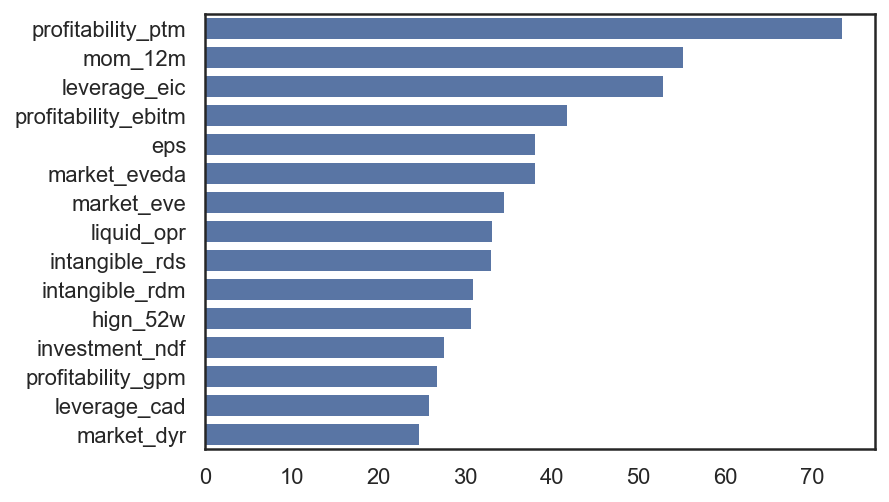

In [28]:
X_train, y_train, X_test, y_test = build_train_test(
    ibuprofen_features,
    ibuprofen_labels,
    train_start="2002-01-01",
    train_end="2016-01-01",
    test_start="2015-12-01",
    test_end="2020-12-01",
    method="multi",
    thres=0.1, 
    extreme=True,
    lower=0.2,
    upper=0.8)

xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric="logloss", n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
importance = pd.Series(data=xgb_clf.get_booster().get_score(importance_type="gain")).sort_values(ascending=False).head(15)
sns.barplot(x=importance, y=importance.index, color="b")
print(f"Classification report on training set:\n")
print(classification_report(y_train, xgb_clf.predict(X_train)))
print(f"Classification report on test set:\n")
print(classification_report(y_test, xgb_clf.predict(X_test)))

In [43]:
ibuprofen_margin = backtest_margin(
    backtest_data,
    ibuprofen_features,
    xgb_clf,
    test_start="2015-12-01",
    test_end="2021-03-01",
    months=3,
    n=30,
    weight="equal",
    method="percent")

Short Only:
Max Drawdown: -0.4811603966913544
Sharpe : -0.6660032556141507
Total Return: -2.1560299447153772
Alpha: -0.351757367993302
Beta: -2.008925375371753
----------------------------------------
Long Only:
Max Drawdown: -0.31439777720866485
Sharpe : 1.767644142946182
Total Return: 3.420549850558489
Alpha: 0.6002481129639234
Beta: 1.7785358027475848
----------------------------------------
Market Neutral:
Max Drawdown: -0.4871086845539446
Sharpe : 0.3961396090918363
Total Return: 1.2645199058431151
Alpha: 0.248490744970622
Beta: -0.23038957262416732
----------------------------------------


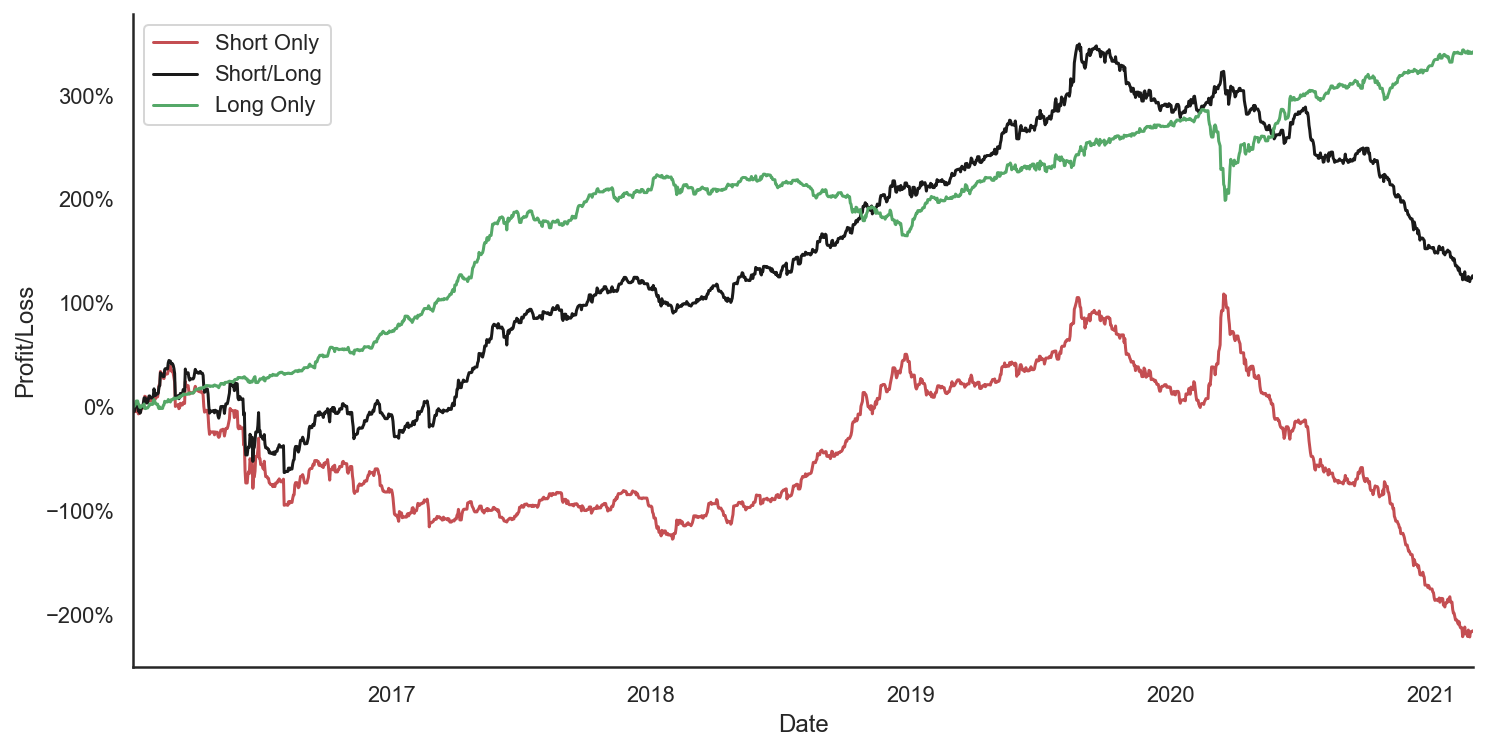

In [9]:
backtest_report(
    backtest_data,
    ibuprofen_features,
    xgb_clf,
    test_start="2015-12-01",
    test_end="2021-03-01",
    months=3,
    n=20,
    weight="equal",
    method="percent")

## Technicals

### Techno
Techno is a strategy based purely on technical indicators.

In [10]:
def compute_rsi(data, window):
    diff = data.diff(1)
    up_chg = 0 * diff
    down_chg = 0 * diff
    up_chg[diff > 0] = diff[diff > 0]
    down_chg[diff < 0] = diff[diff < 0]
    up_chg_avg = up_chg.ewm(com=window - 1, min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window - 1, min_periods=window).mean()
    rs = abs(up_chg_avg / down_chg_avg)
    rsi = 1 - 1 / (1 + rs)
    return rsi

In [11]:
def techno(df):
    windows = [3, 4, 5, 10, 20, 40]
    df["pct_1m"] = df.close.groupby("gvkey").transform(lambda x: x.pct_change(1))
    for window in windows:
        df[f"std_{window}m"] = df.pct_1m.groupby("gvkey").transform(lambda x: x.rolling(window).std())
        df[f"sh_{window}m"] = df.pct_1m.groupby("gvkey").transform(lambda x: x.rolling(window).mean() / x.rolling(window).std())
        df[f"pct_{window}m"] = df.close.groupby("gvkey").transform(lambda x: x.pct_change(window - 1))
        df[f"ema_{window}m"] = df.close.groupby("gvkey").transform(lambda x: x / x.ewm(span=window, adjust=False).mean() -1 )
        df[f"qt_{window}m"] = df.close.groupby("gvkey").transform(lambda x: x.rolling(window).quantile(0.75) / x)
        df[f"scosc_{window}m"] = df.close.groupby("gvkey").transform(lambda x: (x - x.rolling(window).min()) / (x.rolling(window).max() - x.rolling(window).min()))
        df[f"rsi_{window}m"] = df.close.groupby("gvkey").transform(lambda x: compute_rsi(x, window))
    return df.loc[(df.mcap > 1e6) & (df.prccd>5), "high":].drop(columns=["volume", "close"]).dropna()

In [45]:
try:
    techno_features = pd.read_parquet("../data/techno_features.parquet")
except FileNotFoundError:
    # select stocks with market cap > 1 million, trading price > 5 as stock universe
    raw_data = pd.read_parquet("../data/raw-0.1.1.parquet")
    gvkeys = raw_data[(raw_data.mcap > 1e6) & (raw_data.prccd > 5)].index.get_level_values("gvkey").unique()
    universe = raw_data.loc[gvkeys]
    techno_features = build_features(universe, techno, scale="rank")

In [13]:
techno_labels = build_labels(universe, months=3, relative=False)

In [46]:
X_train, y_train, X_test, y_test = build_train_test(
    techno_features,
    techno_labels,
    train_start="2002-01-01",
    train_end="2016-01-01",
    test_start="2015-12-01",
    test_end="2021-03-01",
    method="multi",
    thres=0.1, 
    extreme=True,
    lower=0.2,
    upper=0.8)

Classification report on training set:

              precision    recall  f1-score   support

          -1       0.46      0.35      0.40     19004
           0       0.48      0.29      0.36     17065
           1       0.44      0.65      0.52     22795

    accuracy                           0.45     58864
   macro avg       0.46      0.43      0.43     58864
weighted avg       0.46      0.45      0.44     58864

Classification report on test set:

              precision    recall  f1-score   support

          -1       0.28      0.30      0.29     11775
           0       0.74      0.34      0.46     35325
           1       0.26      0.60      0.36     13949

    accuracy                           0.39     61049
   macro avg       0.42      0.41      0.37     61049
weighted avg       0.54      0.39      0.41     61049



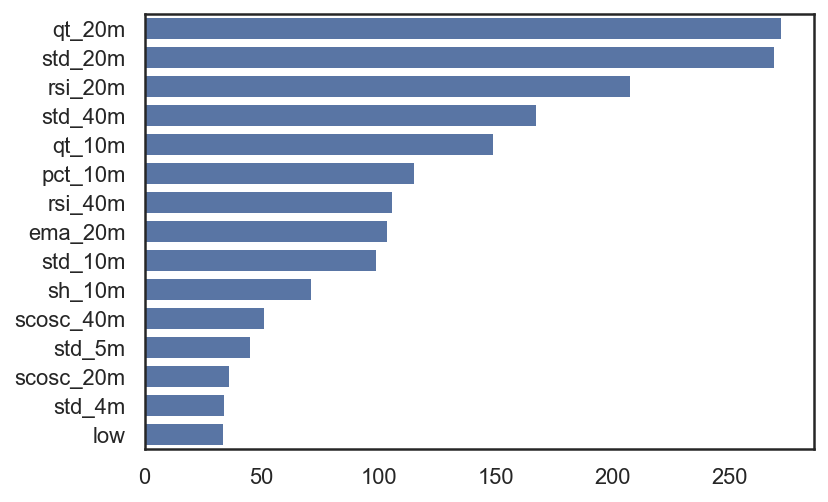

In [47]:
xgb_clf = XGBClassifier(n_estimators=100, 
                        max_depth=1, 
                        learning_rate=0.1, 
#                         eval_metric="logloss", 
                        class_weight='balanced',
                        verbosity=0,
                        n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
importance = pd.Series(data=xgb_clf.get_booster().get_score(importance_type="gain")).sort_values(ascending=False).head(15)
ax = sns.barplot(x=importance, y=importance.index, color="b")
print(f"Classification report on training set:\n")
print(classification_report(y_train, xgb_clf.predict(X_train)))
print(f"Classification report on test set:\n")
print(classification_report(y_test, xgb_clf.predict(X_test)))

In [48]:
techno_margin = backtest_margin(
    backtest_data,
    techno_features,
    xgb_clf,
    test_start="2015-12-01",
    test_end="2021-03-01",
    months=3,
    n=30,
    weight="equal",
    method="percent")

Short Only:
Max Drawdown: -1.0078509449605169
Sharpe : -0.15245569424519093
Total Return: -0.6066441313209934
Alpha: -0.03422034361413284
Beta: -2.7275699028502114
----------------------------------------
Long Only:
Max Drawdown: -0.2808092508276605
Sharpe : 1.657272317968065
Total Return: 2.6434344570879835
Alpha: 0.4617068151972721
Beta: 1.44695939093444
----------------------------------------
Market Neutral:
Max Drawdown: -1.0693011249162627
Sharpe : 0.5210070596759784
Total Return: 2.0367903257669893
Alpha: 0.427486471583139
Beta: -1.2806105119157714
----------------------------------------


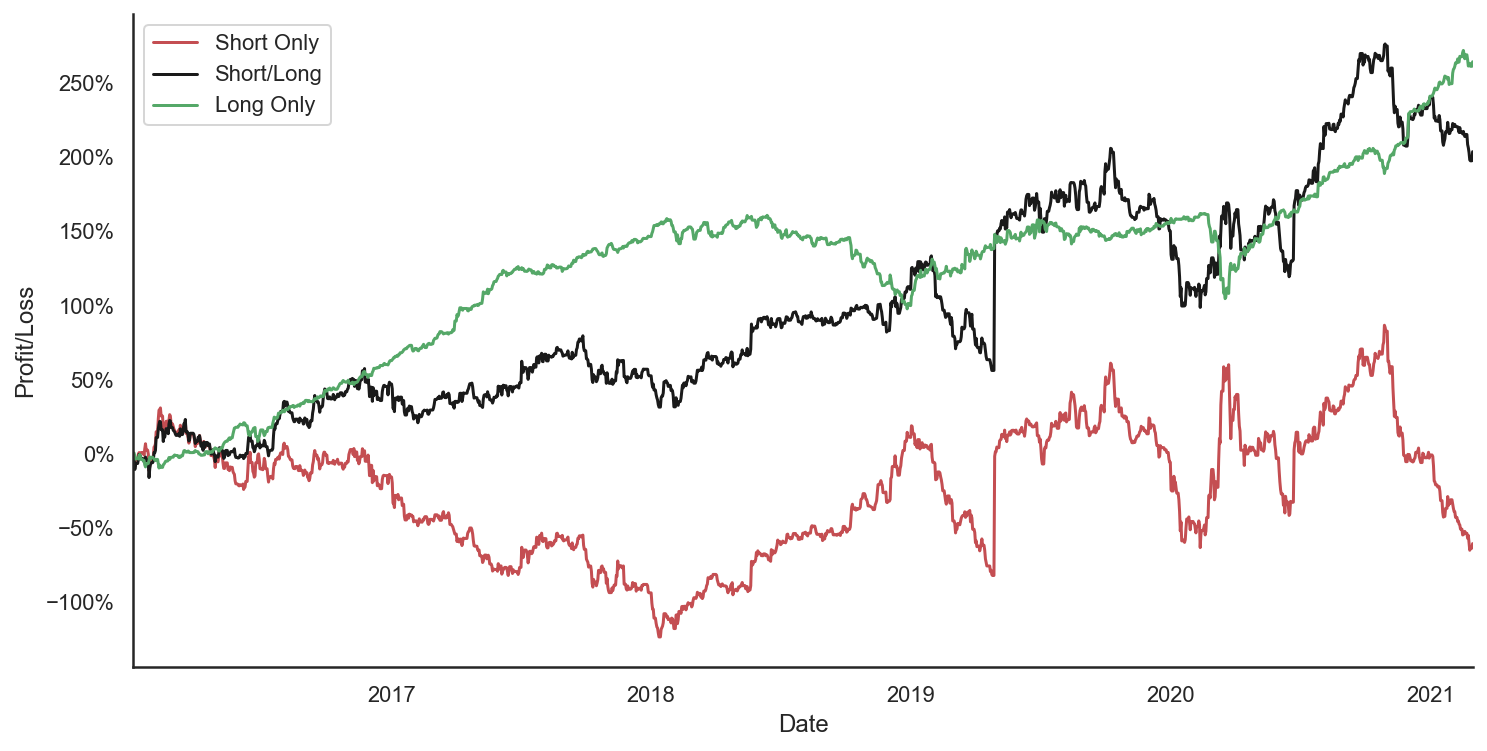

In [16]:
backtest_report(
    backtest_data,
    techno_features,
    xgb_clf,
    test_start="2015-12-01",
    test_end="2021-03-01",
    months=3,
    n=10,
    weight="equal")

## Analyst

### Superstition

Superstition is a strategy that blindly trusts analyst's estinmates and recommendations.

In [17]:
# select stocks with market cap > 1 million, trading price > 5 as stock universe
raw_data = pd.read_parquet("../data/raw-0.1.1.parquet")
gvkeys = raw_data[(raw_data.mcap > 1e6) & (raw_data.prccd > 5)].index.get_level_values("gvkey").unique()
universe = raw_data.loc[gvkeys]

In [18]:
def superstition(df):
    df.dropna(how="all", subset=["numest", "suescore", "medrec"], inplace=True)
    df.eval(
        """
        diff_high = (prccd - ptghigh) / prccd
        diff_med = (prccd - medptg) / prccd
        diff_low = (prccd - ptglow) / prccd
        """,
        inplace=True,
    )
    return df.loc[
        (df.mcap > 1e6) & (df.prccd > 5),
        ["numest",
        "numdown1m",
        "numup1m",
        "diff_high",
        "diff_med",
        "diff_low",
        "suescore",
        "medrec",
        "numdown",
        "numup",
        "numrec",
        "buypct",
        "holdpct",
        "sellpct",
        ],
    ]

In [19]:
superstition_features = build_features(universe, superstition, scale="rank")
superstition_labels = build_labels(universe, months=3, relative=True)

In [49]:
X_train, y_train, X_test, y_test = build_train_test(
    superstition_features,
    superstition_labels,
    train_start="2010-01-01",
    train_end="2016-01-01",
    test_start="2015-12-01",
    test_end="2021-03-01",
    method="multi",
    thres=0.1, 
    extreme=True,
    lower=0.2,
    upper=0.8)

Classification report on training set:

              precision    recall  f1-score   support

          -1       0.58      0.50      0.54     11128
           0       1.00      0.00      0.00      2677
           1       0.56      0.75      0.64     12337

    accuracy                           0.57     26142
   macro avg       0.71      0.42      0.39     26142
weighted avg       0.61      0.57      0.53     26142

Classification report on test set:

              precision    recall  f1-score   support

          -1       0.23      0.44      0.30      9332
           0       1.00      0.00      0.00     30137
           1       0.20      0.64      0.31      9972

    accuracy                           0.21     49441
   macro avg       0.48      0.36      0.20     49441
weighted avg       0.69      0.21      0.12     49441



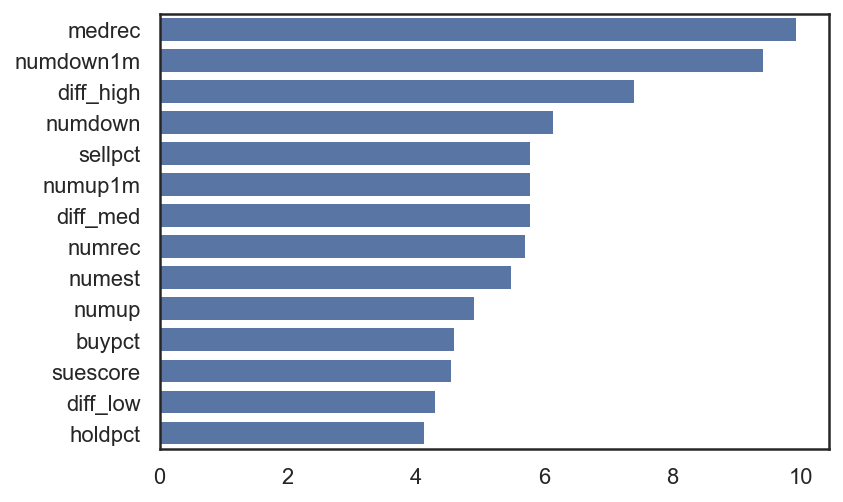

In [50]:
xgb_clf = XGBClassifier(n_estimators=10, max_depth=5, eval_metric="logloss", n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
importance = pd.Series(data=xgb_clf.get_booster().get_score(importance_type="gain")).sort_values(ascending=False)
ax = sns.barplot(x=importance, y=importance.index, color="b")
print(f"Classification report on training set:\n")
print(classification_report(y_train, xgb_clf.predict(X_train)))
print(f"Classification report on test set:\n")
print(classification_report(y_test, xgb_clf.predict(X_test)))

In [51]:
superstition_margin = backtest_margin(
    backtest_data,
    superstition_features,
    xgb_clf,
    test_start="2015-12-01",
    test_end="2021-03-01",
    months=3,
    n=30,
    weight="equal",
    method="percent")

Short Only:
Max Drawdown: -0.41054336838251326
Sharpe : -0.18112544540252729
Total Return: -0.47605218888488043
Alpha: -0.02096625410871245
Beta: -2.337007499814265
----------------------------------------
Long Only:
Max Drawdown: -0.21111008429136496
Sharpe : 0.9604414058353968
Total Return: 1.0664598555798366
Alpha: 0.16178506747386773
Beta: 1.401368594693218
----------------------------------------
Market Neutral:
Max Drawdown: -0.2992412690101396
Sharpe : 0.2598228380277082
Total Return: 0.5904076666949541
Alpha: 0.14081881336515492
Beta: -0.9356389051210472
----------------------------------------


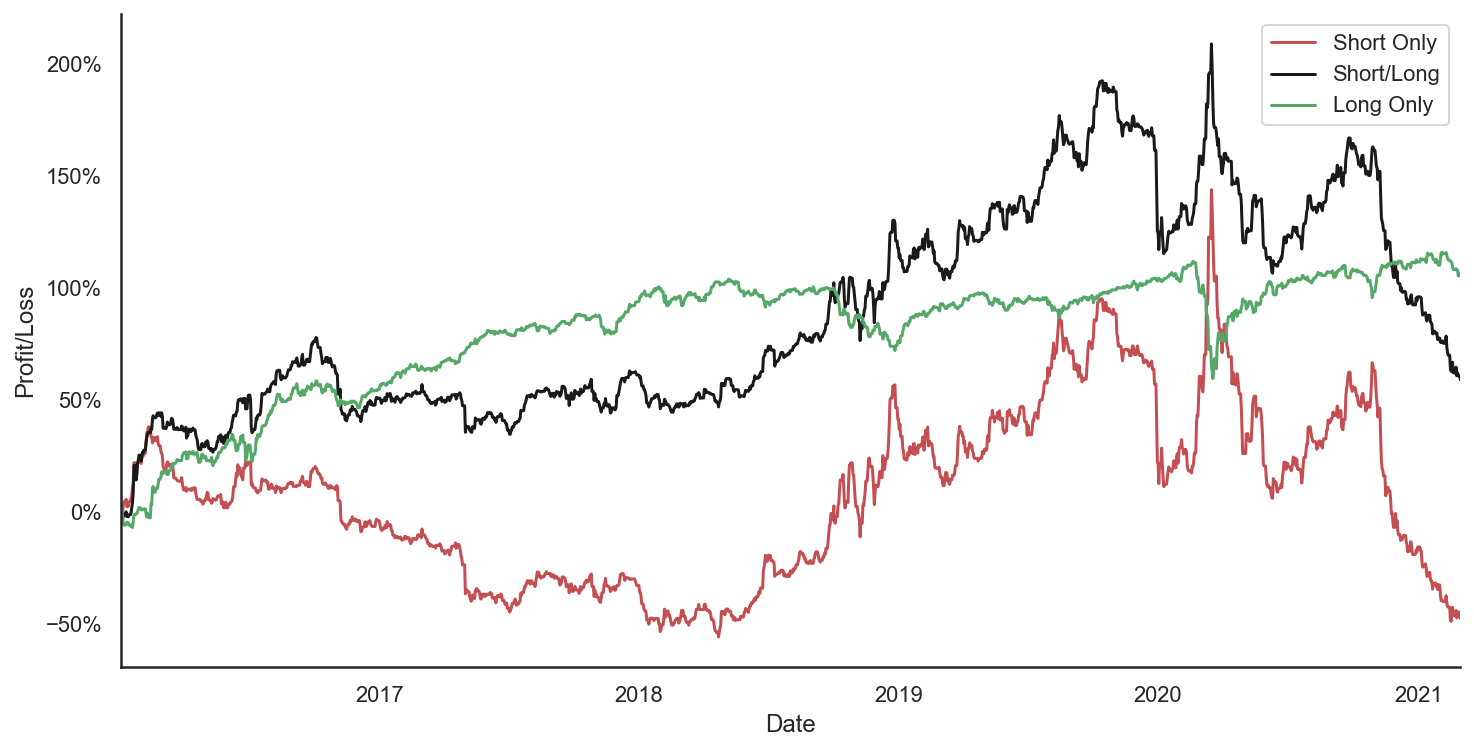

In [22]:
backtest_report(
    backtest_data,
    superstition_features,
    xgb_clf,
    test_start="2015-12-01",
    test_end="2021-03-01",
    months=3,
    n=10,
    weight="equal",
    method="percent")

# All in One
Combine all the features.

In [23]:
all_features = pd.concat([ibuprofen_features, techno_features, superstition_features], axis=1).fillna(0.5)

In [24]:
all_labels = build_labels(universe, months=3, relative=True)

In [52]:
X_train, y_train, X_test, y_test = build_train_test(
    all_features,
    all_labels,
    train_start="2002-01-01",
    train_end="2016-01-01",
    test_start="2015-12-01",
    test_end="2021-03-01",
    method="multi",
    thres=0.1, 
    extreme=True,
    lower=0.2,
    upper=0.8)

Classification report on training set:

              precision    recall  f1-score   support

          -1       0.72      0.72      0.72     27646
           0       0.82      0.07      0.14      5448
           1       0.69      0.81      0.74     29589

    accuracy                           0.70     62683
   macro avg       0.74      0.53      0.53     62683
weighted avg       0.71      0.70      0.68     62683

Classification report on test set:

              precision    recall  f1-score   support

          -1       0.24      0.53      0.33      9332
           0       0.84      0.01      0.03     30137
           1       0.21      0.62      0.32      9972

    accuracy                           0.23     49441
   macro avg       0.43      0.39      0.23     49441
weighted avg       0.60      0.23      0.14     49441



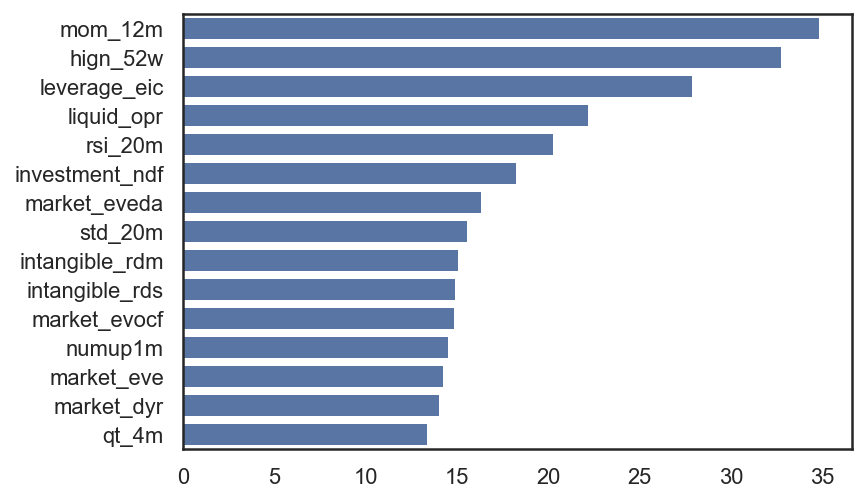

In [80]:
xgb_clf = XGBClassifier(n_estimators=30, max_depth=6, eval_metric="logloss", n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
importance = pd.Series(data=xgb_clf.get_booster().get_score(importance_type="gain")).sort_values(ascending=False).head(15)
sns.barplot(x=importance, y=importance.index, color="b")
print(f"Classification report on training set:\n")
print(classification_report(y_train, xgb_clf.predict(X_train)))
print(f"Classification report on test set:\n")
print(classification_report(y_test, xgb_clf.predict(X_test)))

In [54]:
all_margin = backtest_margin(
    backtest_data,
    all_features,
    xgb_clf,
    test_start="2015-12-01",
    test_end="2021-03-01",
    months=3,
    n=30,
    weight="equal",
    method="percent")

Short Only:
Max Drawdown: -0.4957257900987974
Sharpe : -0.014484727885074463
Total Return: -0.043168707377322785
Alpha: 0.04092635365830976
Beta: -1.6420549718257151
----------------------------------------
Long Only:
Max Drawdown: -0.5315775883438123
Sharpe : 2.0560000975214274
Total Return: 4.27826662114362
Alpha: 0.7687834068056197
Beta: 1.6227509427553244
----------------------------------------
Market Neutral:
Max Drawdown: -0.7069869884727567
Sharpe : 1.3342548477511675
Total Return: 4.235097913766296
Alpha: 0.8097097604639293
Beta: -0.019304029070390544
----------------------------------------


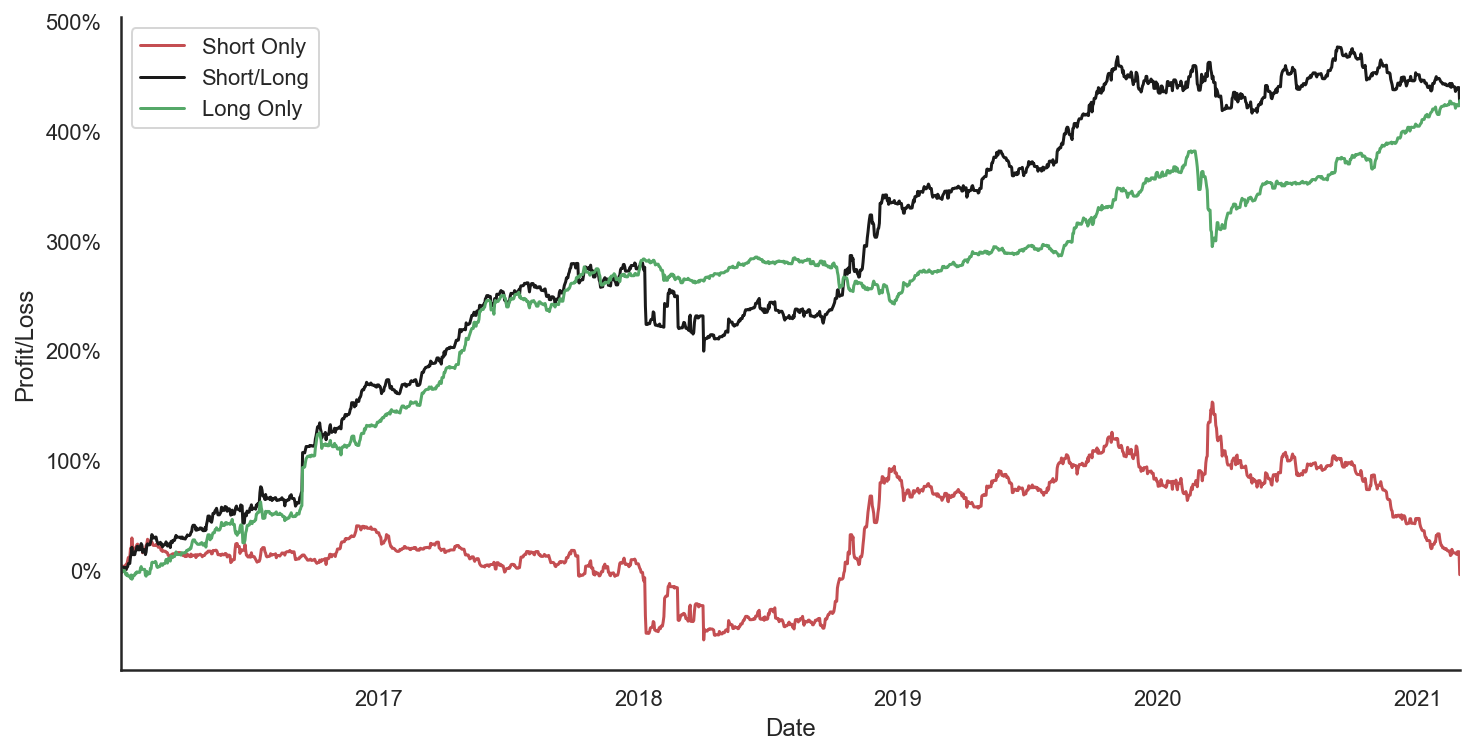

In [81]:
backtest_report(
    backtest_data,
    all_features,
    xgb_clf,
    test_start="2015-12-01",
    test_end="2021-03-01",
    months=3,
    n=10,
    weight="equal",
    method="percent")

# Take My Money Now

In [86]:
short_signal, long_signal = frame_to_signals(all_features, xgb_clf)
short_position, long_position = signals_to_positions(
    short_signal, long_signal, 10, 3, "equal"
)

In [92]:
long_position.xs("2021-03-17", level="date").sort_values(ascending=False)

gvkey
210352    5.0
235767    3.0
238754    3.0
203029    2.0
242279    2.0
101336    2.0
023667    1.0
292387    1.0
281772    1.0
281701    1.0
271916    1.0
220301    1.0
225258    1.0
211427    1.0
210980    1.0
208752    1.0
201633    1.0
102872    1.0
320124    1.0
dtype: float64

In [93]:
short_position.xs("2021-03-17", level="date").sort_values()

gvkey
326866   -4.0
204839   -3.0
318005   -2.0
311699   -2.0
295058   -2.0
273009   -2.0
101467   -2.0
234800   -2.0
241677   -1.0
226216   -1.0
325587   -1.0
282361   -1.0
208821   -1.0
103666   -1.0
101727   -1.0
319665   -1.0
320631   -1.0
322617   -1.0
274558   -1.0
dtype: float64

# Summary

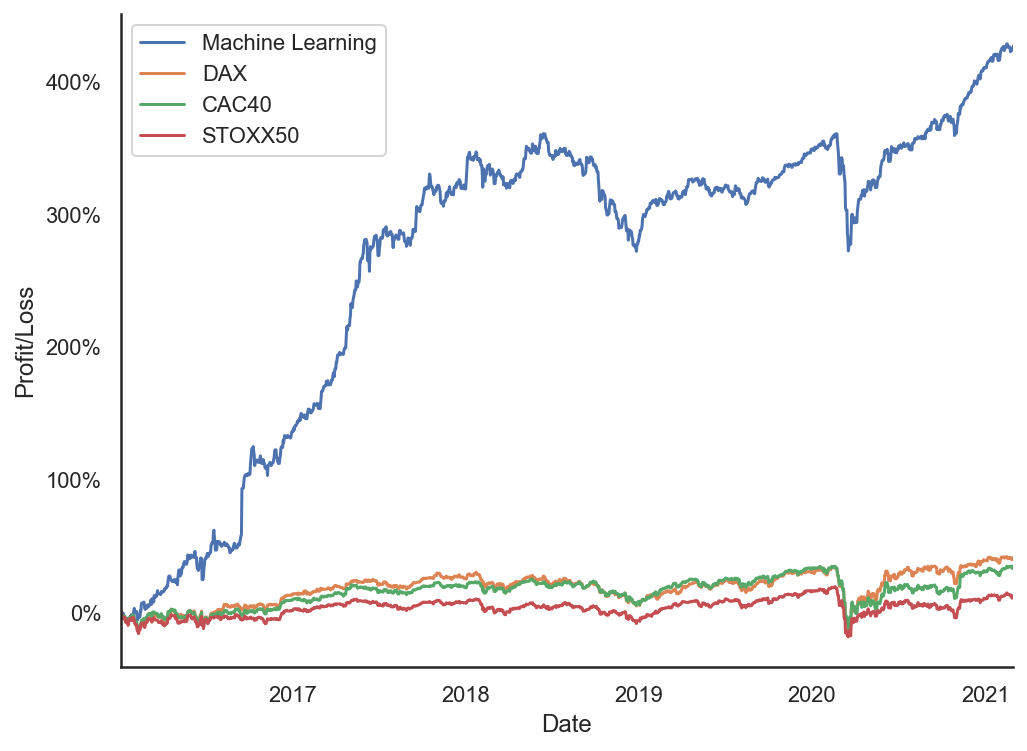

In [78]:
cac40_margin = idx_margin(backtest_data, all_margin, idx="CAC40", method="percent")
dax_margin = idx_margin(backtest_data, all_margin, idx="DAX", method="percent")
stoxx50_margin = idx_margin(backtest_data, all_margin, idx="STOXX50", method="percent")
stoxx600_margin = idx_margin(backtest_data, all_margin, idx="STOXX600", method="percent")
sum_df = pd.DataFrame(
    {
        "Machine Learning": all_margin.fillna(0).cumsum() * 100,
        "DAX": dax_margin.fillna(0).cumsum() * 100,
        "CAC40": cac40_margin.fillna(0).cumsum() * 100,
        "STOXX50": stoxx50_margin.fillna(0).cumsum() * 100,
    }
)
ax = sum_df.plot.line(
    figsize=(8, 6),
    xlabel="Date",
    ylabel="Profit/Loss",
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.despine(top=True, right=True)

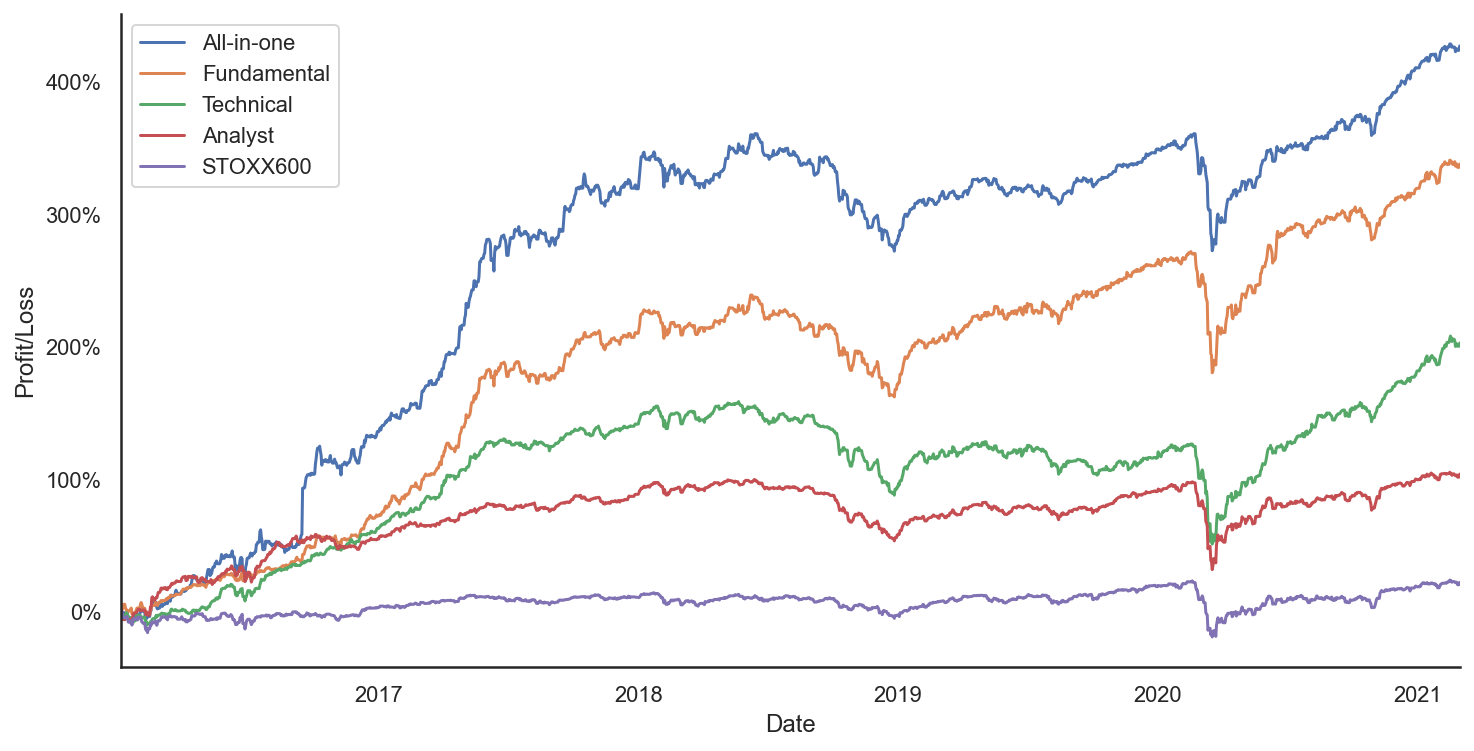

In [94]:
import matplotlib.ticker as mtick
market_margin = idx_margin(backtest_data, all_margin, idx="STOXX600", method="percent")
sum_df = pd.DataFrame(
    {
        "All-in-one": all_margin.fillna(0).cumsum() * 100,
        "Fundamental": ibuprofen_margin.fillna(0).cumsum() * 100,
        "Technical": techno_margin.fillna(0).cumsum() * 100,
        "Analyst": superstition_margin.fillna(0).cumsum() * 100,
        "STOXX600": market_margin.fillna(0).cumsum() * 100,
    }
)
ax = sum_df.plot.line(
    figsize=(12, 6),
    xlabel="Date",
    ylabel="Profit/Loss",
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.despine(top=True, right=True)